# Convulotional Neural Networks

In [14]:
# Install dependencies and libraries
import tensorflow as tf

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Error logging
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

In [32]:
# Import the dataset and metadata
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
# Get the test and train dataset
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [17]:
# Labeling the class names
class_names = metadata.features['label'].names

print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Explore the data

In [18]:
# Get the number of train and test data
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


### Preprocessing

In [33]:
# Preprocessing
# Normalizing the data
def normalize(images, labels):
  # Get the image and the label
  # Convert tensor into float
  images = tf.cast(images, tf.float32)
  # Normalize the image pixel value
  images /= 255
  # Return image and the label
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explore the preprocessd data

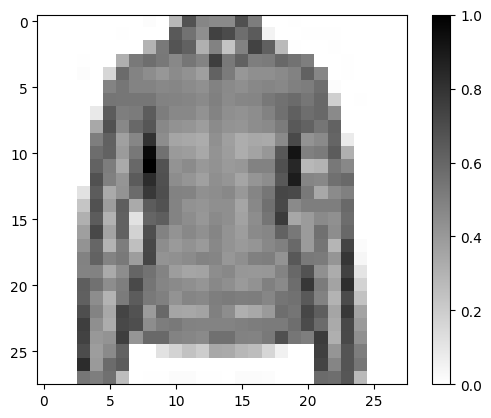

In [20]:
# Take one sample and check it with thenormalizatio and plotting pixel value
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break

# Reshaping into numerical value
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

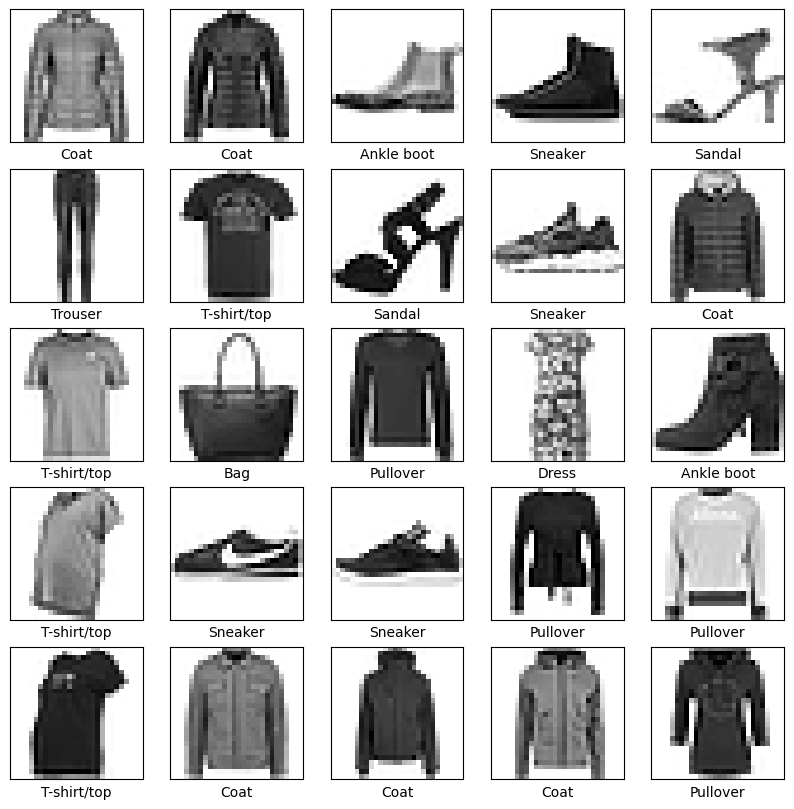

In [21]:
# Plot first 25 images
# Draw the figure
plt.figure(figsize=(10,10))

# Iteration
i = 0
# Get 25 test data
for (image, label) in test_dataset.take(25):
    # Reshape the image into numpy array
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Plotting
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## **Buliding the Convolutional Neural Network**

In [22]:
# Model has following layers in the network
# 32 in first Conv2D for 32 convoluted outputs from that layer
# Padding same means using zeros
# In MaxPooling2D 2x2 is the Maxploo size and stride value is 2
# That mean by 2 positions, matrix move

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

This network layers are:

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D`— Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `tf.keras.layers.Dense` — A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

> Note: Using `softmax` activation and `SparseCategoricalCrossentropy()` has issues and which are patched by the `tf.keras` model. A safer approach, in general, is to use a linear output (no activation function) with `SparseCategoricalCrossentropy(from_logits=True)`.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [23]:
# Compile the model
# Adam optimizer is used
# Loss function is selected as Sparse categeroical cross entropy
# Performace is evaluatd on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [24]:
# Train the model with batch size of 32
# Using cahches for increase the speed

BATCH_SIZE = 32
# Train dataset using for fitting
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset which is going to use testing
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [25]:
# Fit the model
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 28s 5ms/step - loss: 0.4010 - accuracy: 0.8555
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2669 - accuracy: 0.9040
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2163 - accuracy: 0.9197
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1853 - accuracy: 0.9308
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1643 - accuracy: 0.9391
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1349 - accuracy: 0.9500
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1182 - accuracy: 0.9553
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1002 - accuracy: 0.9624
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0867 - accuracy: 0.9682
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.

### Evaluate Accuracy


In [26]:
# Evaluate the accuracy on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.3006 - accuracy: 0.9240
Accuracy on test dataset: 0.9240000247955322


Here, we got 92%. Because, we use 10 epochs and model might be overfitted to the data (600000) data is gone through the model.

## Make predictions

In [27]:
# predict on one batch (32 images)
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 169ms/step


In [28]:
predictions.shape

(32, 10)

32 images have thier own 10 probabilities with ecah classes

In [29]:
# Get the class of the 1st element in the batch
print(class_names[np.argmax(predictions[0])])

Coat


#### Ploting function

In [30]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

<ipython-input-31-296a60fa4da5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,3))


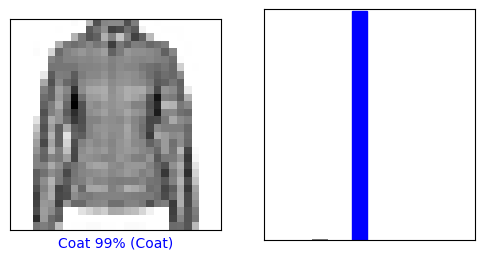

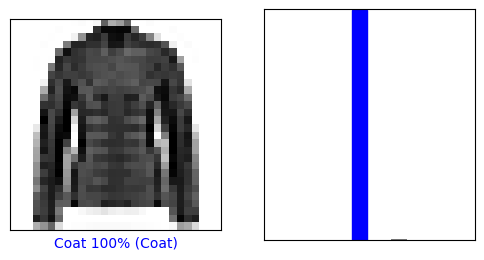

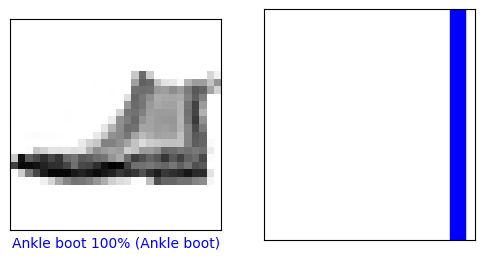

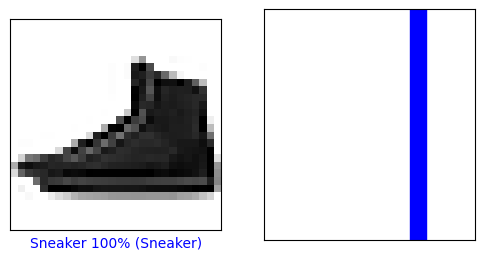

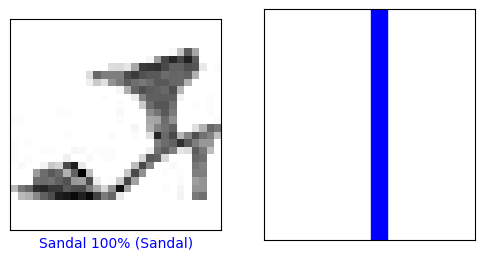

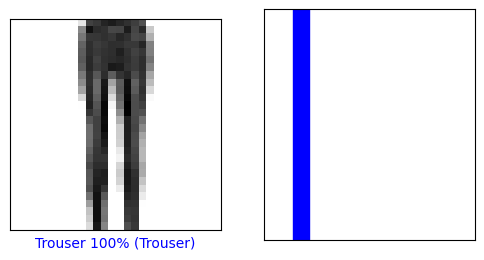

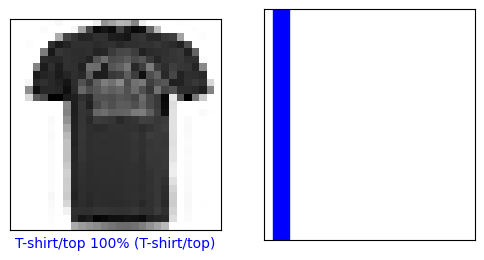

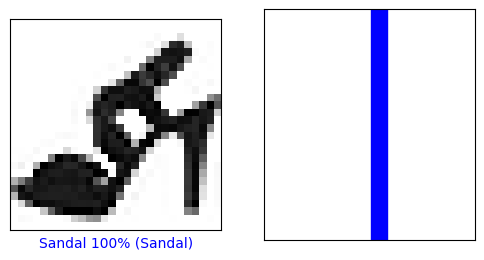

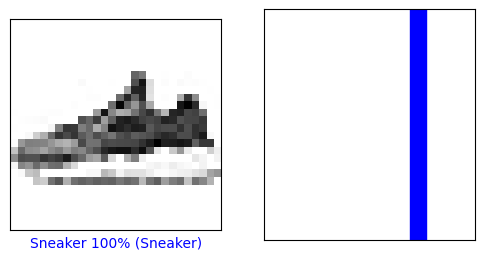

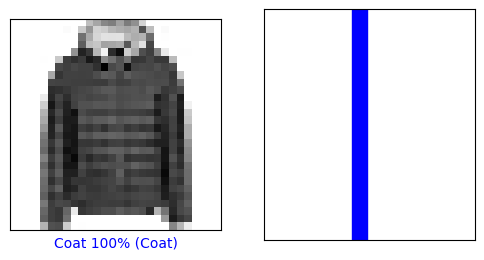

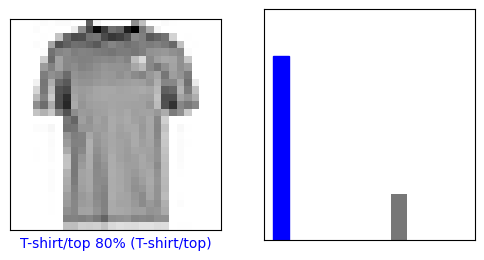

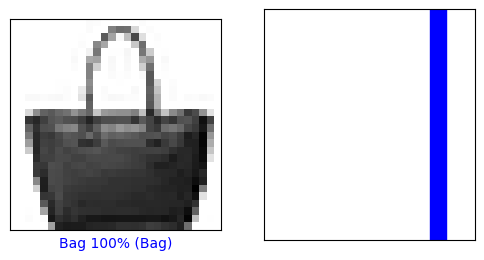

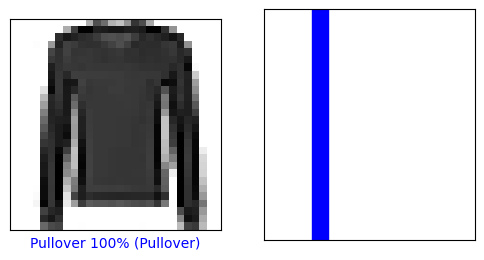

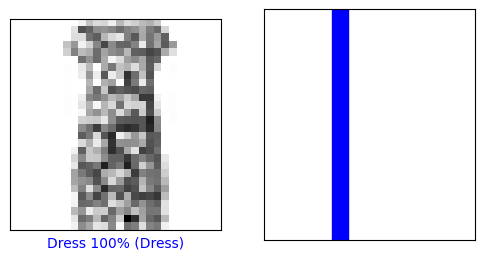

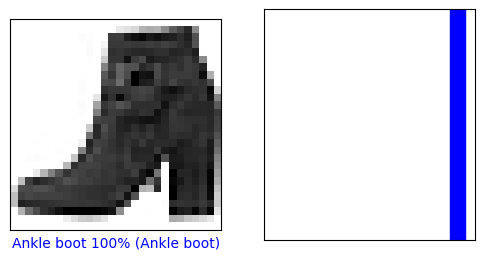

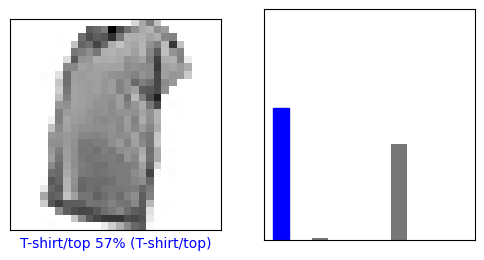

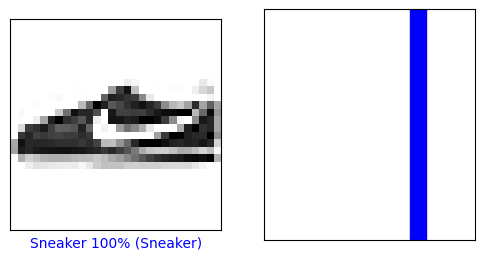

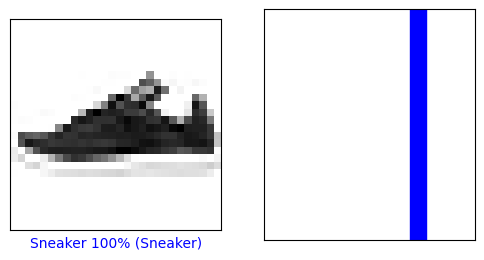

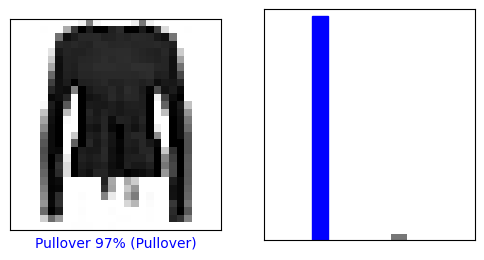

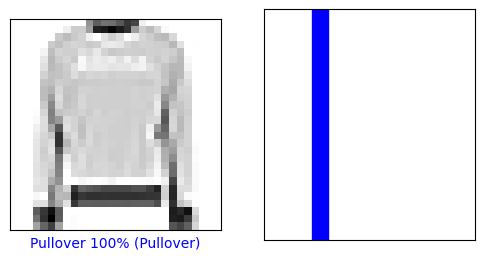

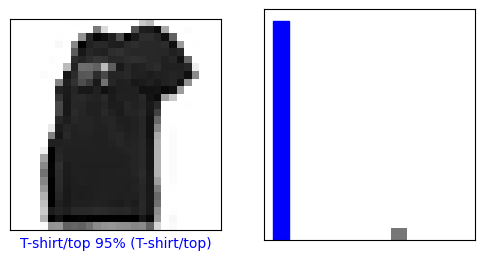

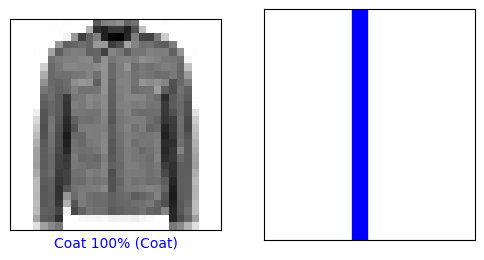

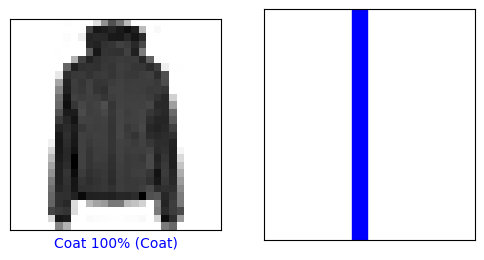

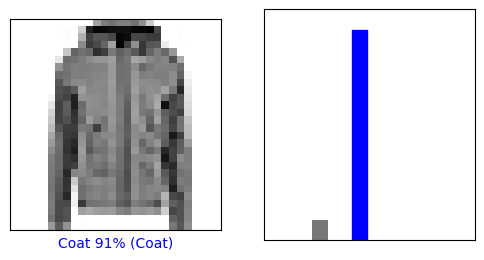

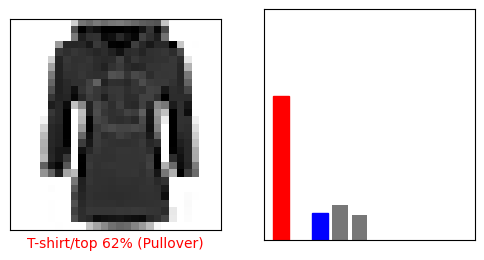

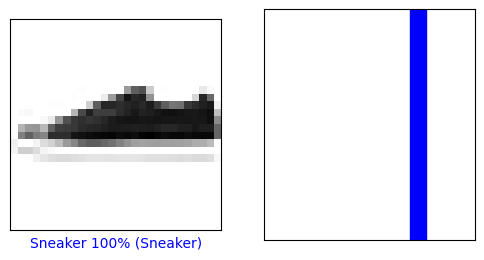

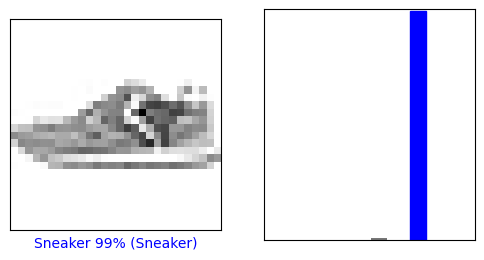

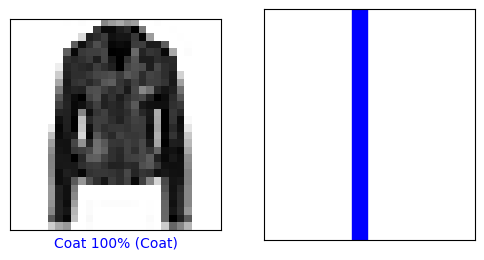

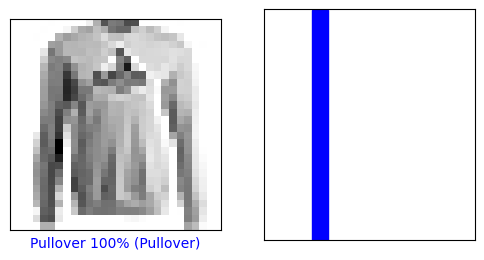

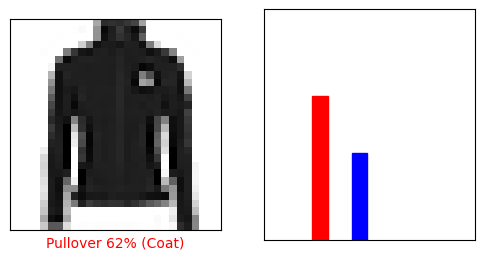

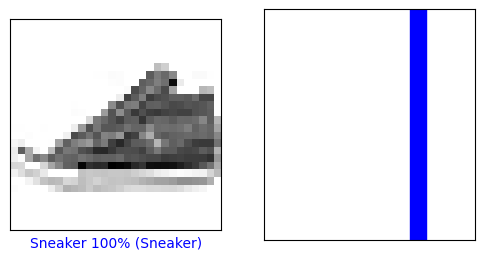

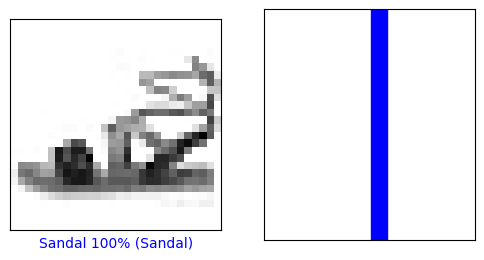

In [31]:
# Plot the reslts of the first batch (32 images)

for i in range (0,32):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(i, predictions, test_labels)

### ***Exercises***

For easyness those code snippets are added to this

In [43]:
# Import the dataset and metadata
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
# Get the test and train dataset
train_dataset, test_dataset = dataset['train'], dataset['test']

In [41]:
# Preprocessing
# Normalizing the data
def normalize(images, labels):
  # Get the image and the label
  # Convert tensor into float
  images = tf.cast(images, tf.float32)
  # Normalize the image pixel value
  images /= 255
  # Return image and the label
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Excercise 1
Set epochs to 1

In [36]:
# Model has following layers in the network
# 32 in first Conv2D for 32 convoluted outputs from that layer
# Padding same means using zeros
# In MaxPooling2D 2x2 is the Maxploo size and stride value is 2
# That mean by 2 positions, matrix move

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Compile the model
# Adam optimizer is used
# Loss function is selected as Sparse categeroical cross entropy
# Performace is evaluatd on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model with batch size of 32
# Using cahches for increase the speed

BATCH_SIZE = 32
# Train dataset using for fitting
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset which is going to use testing
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

# Fit the model
model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

1875/1875 [==============================] - 14s 4ms/step - loss: 0.3961 - accuracy: 0.8572


Accuracy is reduced to 86%

### Exercise 2
Changing number of neurons to 512

In [39]:
# Model has following layers in the network
# 32 in first Conv2D for 32 convoluted outputs from that layer
# Padding same means using zeros
# In MaxPooling2D 2x2 is the Maxploo size and stride value is 2
# That mean by 2 positions, matrix move

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Compile the model
# Adam optimizer is used
# Loss function is selected as Sparse categeroical cross entropy
# Performace is evaluatd on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model with batch size of 32
# Using cahches for increase the speed

BATCH_SIZE = 32
# Train dataset using for fitting
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset which is going to use testing
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

# Fit the model
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 18s 5ms/step - loss: 0.3716 - accuracy: 0.8635
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2432 - accuracy: 0.9098
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1938 - accuracy: 0.9288
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1616 - accuracy: 0.9407
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1308 - accuracy: 0.9518
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1059 - accuracy: 0.9607
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0853 - accuracy: 0.9680
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0670 - accuracy: 0.9750
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0541 - accuracy: 0.9804
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 

Accuracy has Increased to the 98.32%. There might be overfitterd

## Exrercise
Add Dense layer

In [42]:
# Model has following layers in the network
# 32 in first Conv2D for 32 convoluted outputs from that layer
# Padding same means using zeros
# In MaxPooling2D 2x2 is the Maxploo size and stride value is 2
# That mean by 2 positions, matrix move

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Compile the model
# Adam optimizer is used
# Loss function is selected as Sparse categeroical cross entropy
# Performace is evaluatd on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model with batch size of 32
# Using cahches for increase the speed

BATCH_SIZE = 32
# Train dataset using for fitting
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset which is going to use testing
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

# Fit the model
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 15s 4ms/step - loss: 0.3984 - accuracy: 0.8537
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2512 - accuracy: 0.9080
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2073 - accuracy: 0.9233
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1738 - accuracy: 0.9350
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1502 - accuracy: 0.9438
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1284 - accuracy: 0.9524
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1066 - accuracy: 0.9603
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0918 - accuracy: 0.9664
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0815 - accuracy: 0.9697
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.06

Performance has increased. Overfitting might not as previously.

### Exercise 4
Without normalizing

In [44]:
# Model has following layers in the network
# 32 in first Conv2D for 32 convoluted outputs from that layer
# Padding same means using zeros
# In MaxPooling2D 2x2 is the Maxploo size and stride value is 2
# That mean by 2 positions, matrix move

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Compile the model
# Adam optimizer is used
# Loss function is selected as Sparse categeroical cross entropy
# Performace is evaluatd on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model with batch size of 32
# Using cahches for increase the speed

BATCH_SIZE = 32
# Train dataset using for fitting
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset which is going to use testing
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

# Fit the model
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 13s 4ms/step - loss: 0.4583 - accuracy: 0.8637
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2565 - accuracy: 0.9059
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2268 - accuracy: 0.9179
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1992 - accuracy: 0.9259
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1803 - accuracy: 0.9334
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1648 - accuracy: 0.9389
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1407 - accuracy: 0.9474
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1293 - accuracy: 0.9521
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1117 - accuracy: 0.9580
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.

Performance is reduced

In [56]:
# Make a prediction to check whether output has effect

# predict on one batch (32 images)
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

# Get the class of the 1st element in the batch
print(class_names[np.argmax(predictions[0])])

# True value
print(class_names[test_labels[0]])

1/1 [==============================] - 0s 20ms/step
Coat
Coat
